We consider an LTI system that represents a longitudinal aircraft dynamics. The matrix $A$ represents stability derivatives of a Boeing 747 aircraft cruising at an altitude of 40kft with speed 774 ft/sec.

Let $\dot{x} = Ax + B u$, with state $x = [u,\alpha,\dot{\theta}, \theta]^T \in \mathbb{R}^4$ comprised of deviations in aircraft speed, angle of attack, pitch-rate, and pitch angle respectively. The matrix $A$ is 
$$
A = \begin{pmatrix}
-0.0030 & 0.0390 & 0 & -0.3220 \\
-0.0650 & -0.3190 & 7.7400 & 0 \\
0.0200 & -0.1010 & -0.4290 & 0 \\
0 & 0 & 1 & 0
\end{pmatrix},
$$
and 
$$
B = \begin{pmatrix}
0.0100 \\ -0.1800 \\ -1.1600 \\ 0
\end{pmatrix}
$$
The input is $u \in [-13.3,13.3] \in \mathbb{R}$ (measured in degrees).


---
References:
1. A. Bryson. Control of Spacecraft and Aircraft. Princeton Univ. Press, 1994.
2. S. Kaynama, M. Oishi. Schur-Based decomposition for reachability analysis of Linear-Time-Invariant systems. Joint 48th IEEE Conf on Decision and Control, 2009.

## Inhomogeneous case

Set $A$ and $B$ in $dx/dt = Ax + Bu$.

In [1]:
import sys
sys.path.append('..')

from src.lgg import compute_flowpipe, plot_flowpipe
from lib.polyFunctions_core import BoxInfty

In [2]:
# system coefficient matrix
A = matrix(RDF, 4, 4)
A.set_row(0, [-0.0030 , 0.0390 , 0 , -0.3220])
A.set_row(1, [-0.0650 , -0.3190 , 7.7400 , 0])
A.set_row(2, [0.0200 , -0.1010 , -0.4290 , 0])
A.set_row(3, [0 , 0 , 1 , 0])

B = matrix(RDF, 4, 1)
B.set_column(0,[0.01, -0.18, -1.16, 0])

# time horizon 
T = 2

# input range
U = BoxInfty(lengths=[[-13.3,13.3]])

# initial condition 
#X0 = [1,1,1,0] 
X0 = BoxInfty(center = [1,1,1,0], radius = 0.01, base_ring = RDF)
#X0 = BoxInfty(lengths = [[-1,1],[-1,1],[-1,1],[-1,1]], base_ring = RDF) 

# time discretization 
tau = 1e-1

In [3]:
%%time 
fp = compute_flowpipe(A, X0, B, U, time_horizon = T, time_step = tau, directions={'select':'box'}, base_ring = QQ, solver='GLPK', verbose=0)

CPU times: user 790 ms, sys: 154 ms, total: 944 ms
Wall time: 616 ms


## Homogeneous case

Solve: $dx/dt = Ax$.

In [14]:
import sys
sys.path.append('..')

from src.lgg import compute_flowpipe, plot_flowpipe
from lib.polyFunctions_core import BoxInfty

# this is a slightly modified matrix, obtained from Aircraft4D model
# dx/dt = Ax

A = matrix(RDF, 5, 5)
A.set_row(0, [-0.003 , 0.039 ,   0.0, -0.322 ,  0.01])
A.set_row(1, [-0.065 ,-0.319 ,  7.74 ,   0.0 , -0.18])
A.set_row(2, [  0.02 ,-0.101 ,-0.429  ,  0.0  ,-1.16])
A.set_row(3, [   0.0 ,   0.0 ,   1.0   , 0.0 ,   0.0])
A.set_row(4, [   0.0  ,  0.0  ,  0.0    ,0.0,    0.0])

# time horizon 
T = 2

# initial condition 
#X0 = [1,1,1,0,0] 
X0 = BoxInfty(center = [1,1,1,0,0], radius = 0.1, base_ring = RDF)
#X0 = BoxInfty(lengths = [[-1,1],[-1,1],[-1,1],[-1,1],[-13.3,13.3]], base_ring = RDF)

# time discretization 
tau = 1e-1

In [18]:
%%time
fp = compute_flowpipe(A, X0, time_horizon = T, time_step = tau, directions={'select':'box'}, base_ring=QQ, solver='GLPK', verbose=0)

CPU times: user 514 ms, sys: 159 ms, total: 673 ms
Wall time: 482 ms


*Remark.* If $T$ is "big" or if $\tau$ is "small", we get ```MIPSolverException```. For instance, try with $T=1$ and $\tau = 1e-2$. However, if $T=0.01$ and $\tau = 1e-2$, then it works properly. Below, we try with another solver.

## Plots

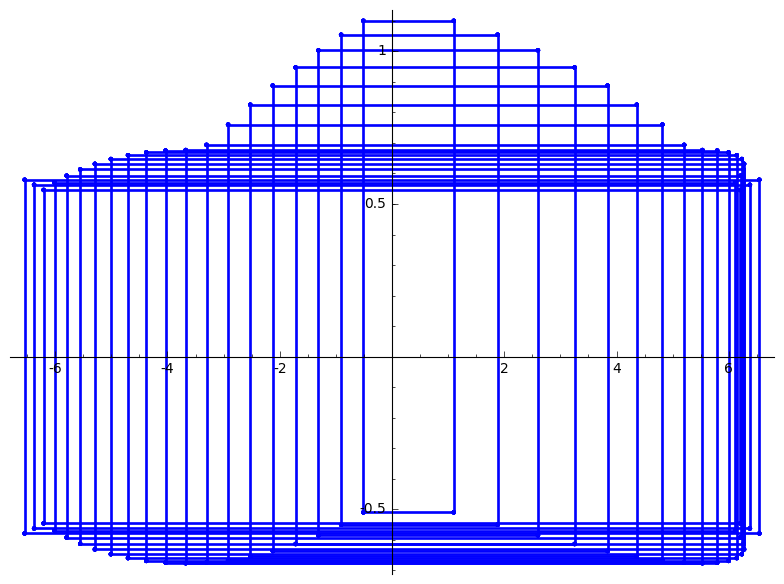

In [19]:
plot_flowpipe(fp, projection_directions = [1,2])

## Open Issues

### Choice of base_ring for the initial condition

*Observations*:

* with $T=2$, $A$ and $B$ as `RDF`, and $X0 = [1,1,1,0]$ (a point), $\tau = 1e-1$ it works, directions=box, base_ring=RDF, it works. However, it does not work if we change $X0$ by a box. $N=20$. Here GLPK takes 387ms, and Gurobi takes 663ms.

* the same conditions as the last point, but we change $X0$ by a box: `X0 = BoxInfty(center = [1,1,1,0], radius = 0.0001) # gives MIPSolverException`. 

* $T=2$, $A$ and $B$ as `RDF`, with X0 = BoxInfty(center = [1,1,1,0], radius = 0.01, base_ring=RDF) # gives MIPSolverException` and `fp = compute_flowpipe(A, X0, B, U, time_horizon = T, time_step = tau, directions={'select':'box'}, base_ring = QQ, solver='GLPK', verbose=0)` it works.
    

In [ ]:
import sys
sys.path.append('..')

from src.lgg import compute_flowpipe, plot_flowpipe
from lib.polyFunctions_core import BoxInfty

# not mandatory
import numpy as np
from src.lgg import PolyhedronToHSpaceRep, PolyhedronFromHSpaceRep, polyhedron_linear_map, matrix_sup_norm, polyhedron_sup_norm, supp_fun_polyhedron
from scipy.linalg import expm


# system coefficient matrix
A = matrix(RDF, 4, 4)
A.set_row(0, [-0.0030 , 0.0390 , 0 , -0.3220])
A.set_row(1, [-0.0650 , -0.3190 , 7.7400 , 0])
A.set_row(2, [0.0200 , -0.1010 , -0.4290 , 0])
A.set_row(3, [0 , 0 , 1 , 0])

B = matrix(RDF, 4, 1)
B.set_column(0,[0.01, -0.18, -1.16, 0])

# time horizon 
T = 2

# input range
U = BoxInfty(lengths=[[-13.3,13.3]])

# initial condition 
#X0 = [1,1,1,0] 
X0 = BoxInfty(center = [1,1,1,0], radius = 0.01, base_ring = RDF)
#X0 = BoxInfty(lengths = [[-1,1],[-1,1],[-1,1],[-1,1]], base_ring = RDF) 

# time discretization 
tau = 1e-1

In [ ]:
%%time 
fp = compute_flowpipe(A, X0, B, U, time_horizon = T, time_step = tau, directions={'select':'box'}, base_ring = QQ, solver='GLPK', verbose=0)

In [ ]:
X0.base_ring(), B.base_ring()

In [ ]:
base_ring = QQ; n=4

V = polyhedron_linear_map(B, U, base_ring = QQ)
Phi_tau = expm(np.multiply(A, tau))
expX0 = polyhedron_linear_map(Phi_tau, X0, base_ring = base_ring)
tau_V = polyhedron_linear_map(tau*np.identity(4), V)
Ainfty = matrix_sup_norm(A)
RX0 = polyhedron_sup_norm(X0)
RV = polyhedron_sup_norm(V)


unitBall = BoxInfty(center = zero_vector(n), radius = 1, base_ring = base_ring)
alpha_tau = (exp(tau*Ainfty) - 1 - tau*Ainfty)*(RX0 + RV/Ainfty)
alpha_tau_B = polyhedron_linear_map(alpha_tau*np.identity(4), unitBall)

aux = expX0.Minkowski_sum(tau_V)
Omega0 = X0.convex_hull(aux.Minkowski_sum(alpha_tau_B))

beta_tau = (exp(tau*Ainfty) - 1 - tau*Ainfty)*(RV/Ainfty)

beta_tau_B = polyhedron_linear_map(beta_tau*np.identity(n), unitBall, base_ring=RDF)

W_tau = tau_V.Minkowski_sum(beta_tau_B)

In [ ]:
Omega0.base_ring(), W_tau.base_ring()

In [ ]:
Omega0.inequalities_list()

In [ ]:
base_ring = RDF
v = vector(base_ring, 4); v

In [ ]:
d = [-1,0,0,0]

supp_fun_polyhedron(Omega0, d, solver='Gurobi', verbose=1)

In [ ]:
d = [-1,-1,-2,-3]

supp_fun_polyhedron(W_tau, d, solver='Gurobi', verbose=1)